In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import *
import src.models.similarity_matrix as sm

Data loading

In [78]:

# Define a tuple of file paths and column names
files_and_columns = (
    ('data/paths_finished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']),
    ('data/paths_unfinished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']),
    ('data/articles.tsv', ['article']),
    ('data/categories.tsv', ['article', 'category'])
)

def read_files(file_tuples):
    dataframes = []
    for path, column_names in file_tuples:
        df = pd.read_csv(path, sep='\t', comment='#', names=column_names, header=None)
        dataframes.append(df)
    return dataframes

paths_finished, paths_unfinished, articles, categories  = read_files(files_and_columns)

### Categories distribution in start and end paths between finished and unfinished games

In [79]:
def find_categories_start_end(paths) :

    paths["start"] = paths["path"].apply(lambda x: x.split(";")[0])
    if "target" in paths.columns:
        paths["end"] = paths["target"]
    else :
        paths["end"] = paths["path"].apply(lambda x: x.split(";")[-1])
    paths["start_category"] = paths["start"].apply(lambda x: categories[categories["article"] == x]["category"].values[0].split(".")[1] if x in categories["article"].values else None)
    paths["end_category"] = paths["end"].apply(lambda x: categories[categories["article"] == x]["category"].values[0].split(".")[1] if x in categories["article"].values else None)

    return paths

paths_finished = find_categories_start_end(paths_finished)
paths_unfinished = find_categories_start_end(paths_unfinished)

In [80]:
paths_finished["finished"] = 1
paths_unfinished["finished"] = 0
paths = pd.concat([paths_finished, paths_unfinished], join='inner')

In [81]:
paths_melted = paths.melt(
    id_vars=["finished"],
    value_vars=["start_category", "end_category"],
    var_name="category_type",
    value_name="category"
)
paths_melted

,finished,category_type,category
0,1,start_category,History
1,1,start_category,History
2,1,start_category,History
3,1,start_category,History
4,1,start_category,History
...,...,...,...
152381,0,end_category,Science
152382,0,end_category,Language_and_literature
152383,0,end_category,Music
152384,0,end_category,People


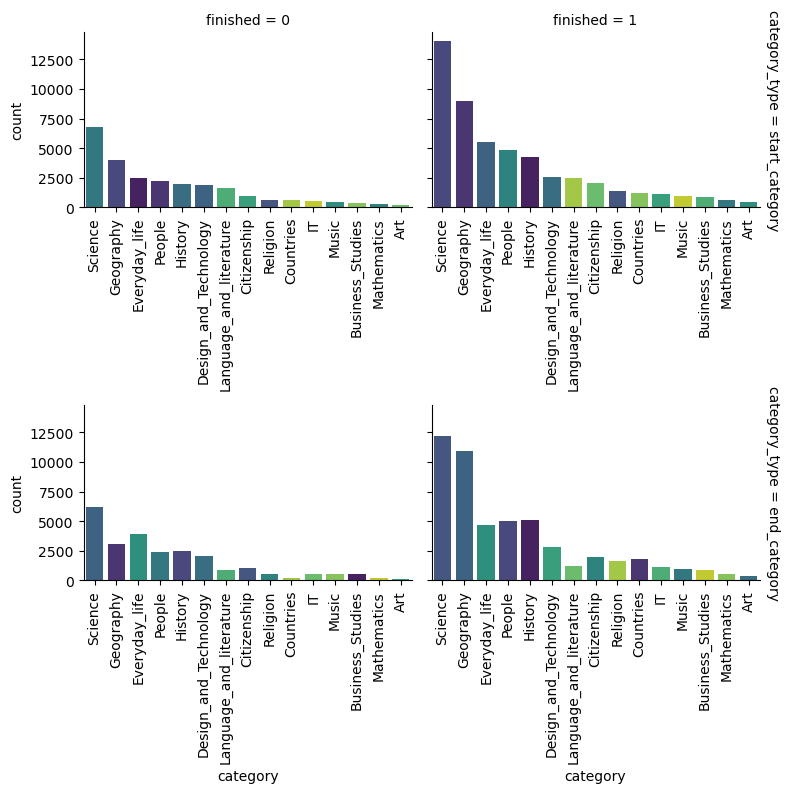

In [90]:
import seaborn as sns

g = sns.FacetGrid(
    data=paths_melted,
    col="finished",
    row="category_type",
    sharey=True,
    sharex=False,
    # sharex="col",
    margin_titles=True,
    height=4,
)
g.map_dataframe(
    sns.countplot,
    x="category",
    hue="category",
    order=paths_melted['category'].value_counts().index,  # Order by frequency
    palette=sns.color_palette("viridis", n_colors=paths_melted['category'].nunique()),
)
# rotate x axis labels
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()

### Comparison of duration of path between starting subject and ending subject

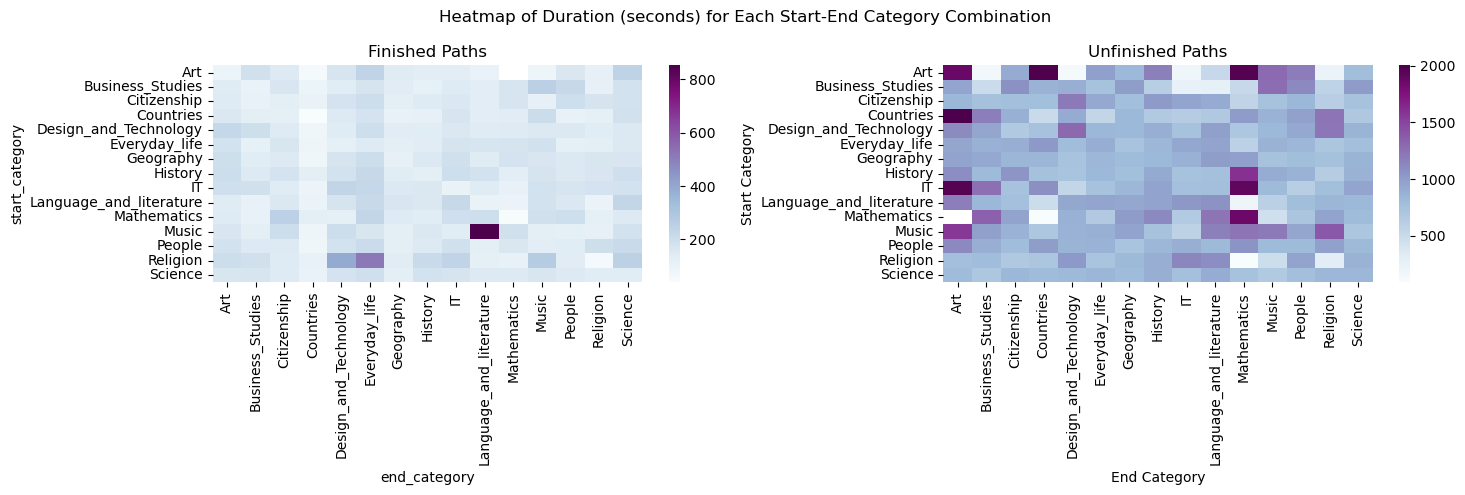

In [83]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='durationInSec', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='durationInSec',
                                                    aggfunc='mean')

sns.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sns.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of Duration (seconds) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Comparison of length of path between starting subject and ending subject

In [84]:
paths_finished["steps_count"] = paths_finished["path"].apply(lambda x: len(x.split(";")))
paths_unfinished["steps_count"] = paths_unfinished["path"].apply(lambda x: len(x.split(";")))

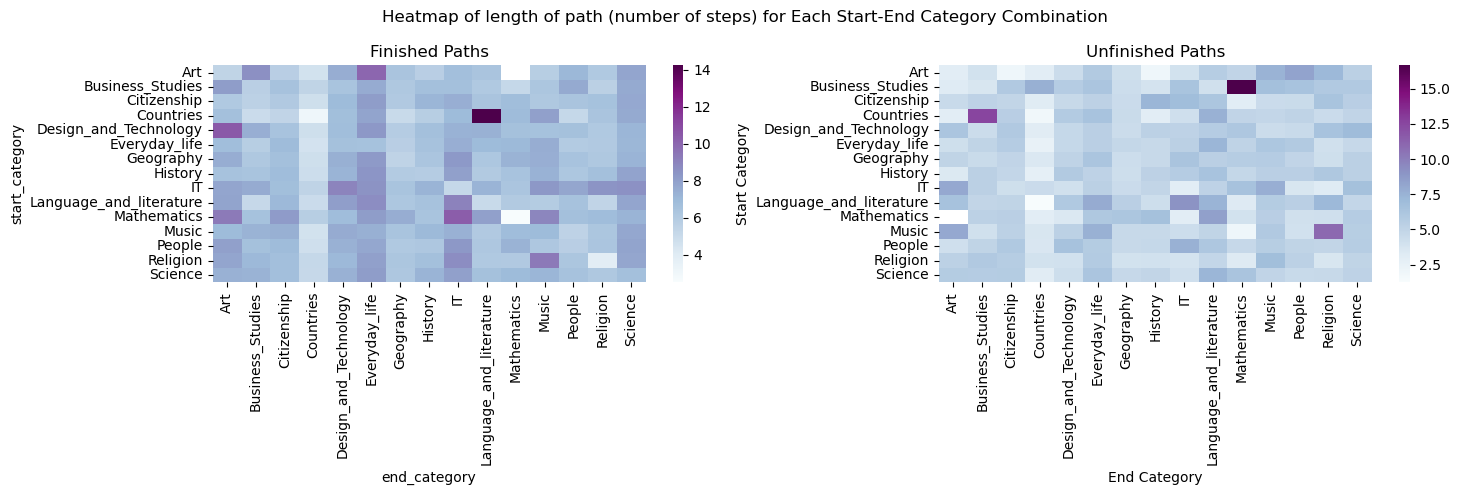

In [85]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='steps_count', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='steps_count',
                                                    aggfunc='mean')

sns.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sns.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of length of path (number of steps) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Comparison of rating between starting subject and ending subject

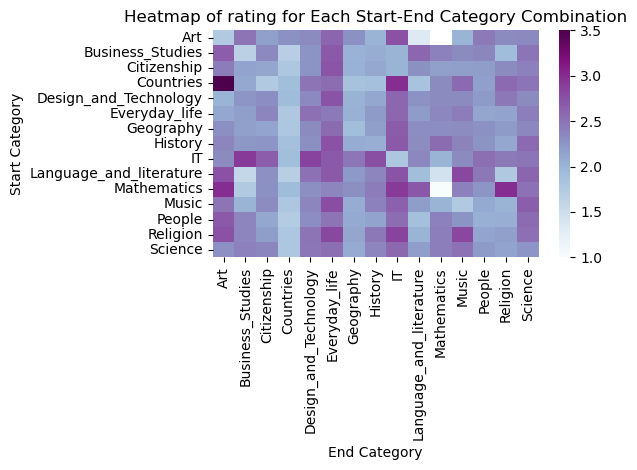

In [86]:
import seaborn as sns


path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sns.heatmap(path_finished_length_categories , cmap='BuPu')
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Correlation between number of steps, duration and rating ?

In [94]:
from scipy import stats
stats_analysis_finished = paths_finished[["durationInSec", "rating", "steps_count"]]
stats_analysis_finished.describe()

,durationInSec,rating,steps_count
count,51318.000000,28501.000000,51318.000000
mean,158.276199,2.269780,6.757434
std,360.841904,1.110439,4.680718
min,0.000000,1.000000,1.000000
25%,60.000000,1.000000,5.000000
50%,107.000000,2.000000,6.000000
75%,183.000000,3.000000,8.000000
max,35091.000000,5.000000,435.000000


In [104]:
stats_analysis_finished.dropna(inplace=True)
p = stats.pearsonr(stats_analysis_finished["durationInSec"], stats_analysis_finished["rating"])
s = stats.spearmanr(stats_analysis_finished["durationInSec"], stats_analysis_finished["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

Pearson correlation: PearsonRResult(statistic=0.25363724438251817, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.5442820373498544, pvalue=0.0)


C:\Users\camil\AppData\Local\Temp\ipykernel_29240\2906730093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_analysis_finished.dropna(inplace=True)


In [106]:
p = stats.pearsonr(stats_analysis_finished["durationInSec"], stats_analysis_finished["steps_count"])
s = stats.spearmanr(stats_analysis_finished["durationInSec"], stats_analysis_finished["steps_count"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

Pearson correlation: PearsonRResult(statistic=0.3614339811340806, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.7021997026200336, pvalue=0.0)


In [105]:
p = stats.pearsonr(stats_analysis_finished["rating"], stats_analysis_finished["steps_count"])
s = stats.spearmanr(stats_analysis_finished["rating"], stats_analysis_finished["steps_count"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

Pearson correlation: PearsonRResult(statistic=0.40374856999510683, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.5539921093665069, pvalue=0.0)


In [108]:
from scipy import stats
stats_analysis_unfinished = paths_unfinished[["durationInSec","steps_count"]]
stats_analysis_unfinished.describe()

,durationInSec,steps_count
count,24875.000000,24875.000000
mean,835.296884,5.197789
std,881.287961,5.772234
min,4.000000,1.000000
25%,86.000000,2.000000
50%,261.000000,4.000000
75%,1831.000000,7.000000
max,9089.000000,235.000000


In [109]:
p = stats.pearsonr(stats_analysis_finished["durationInSec"], stats_analysis_finished["steps_count"])
s = stats.spearmanr(stats_analysis_finished["durationInSec"], stats_analysis_finished["steps_count"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

Pearson correlation: PearsonRResult(statistic=0.3614339811340806, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.7021997026200336, pvalue=0.0)
